# LSTM Networks for predicting cancer by looking at fused genes

In [0]:
# This code has been written by Stefano Brilli, s249914@studenti.polito.it
# Last update on Oct 11th
# Please note that this code can be used just for running the training phase.
# In the future here will be possible testing the model

%tensorflow_version 1.x
import tensorflow as tf
import datetime, os
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, auc
import string
import utils as utl
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
%matplotlib inline

plt.style.use('dark_background')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Parameters definition

In [0]:
# Paths
base_dir="./drive/My Drive/Colab Notebooks/Bioinformatics/Project/"
sub_dir = datetime.datetime.strftime(datetime.datetime.now(), '%Y%m%d-%H%M%S')
model_dir = base_dir + sub_dir

training_set_path = base_dir + 'datasets/bio_translated_training.csv'
testing_set_path = base_dir + 'datasets/bio_translated_testing.csv'
parameters_path  = base_dir + 'datasets/parameters.json'

# Load parameters from JSON file to Python dictionary
params=utl.load_parameters(parameters_path)

## Data preprocessing

In [0]:
# Training set: first four proteins bins
proteins_train, labels_train, vocab_to_int_train, int_to_vocab_train = utl.read_data(training_set_path)
proteins_test, labels_test, vocab_to_int_test, int_to_vocab_test = utl.read_data(testing_set_path)

# if len(vocab_to_int_train) >= len(vocab_to_int_test):
#   vocab_to_int = vocab_to_int_train
#   int_to_vocab = int_to_vocab_train
# else:
#   vocab_to_int = vocab_to_int_test
#   int_to_vocab = int_to_vocab_test

len_indexes = [len(vocab_to_int_train), len(vocab_to_int_test)]
max_len_index = len_indexes.index(max(len_indexes))

if max_len_index == 0:
  vocab_to_int = vocab_to_int_train
  int_to_vocab = int_to_vocab_train
else:
  vocab_to_int = vocab_to_int_test
  int_to_vocab = int_to_vocab_test

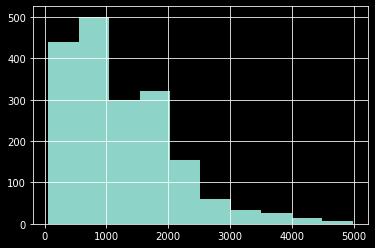

count    1856.000000
mean     1244.736530
std       850.015475
min        60.000000
25%       564.000000
50%      1030.500000
75%      1686.250000
max      4981.000000
dtype: float64

In [5]:
# Training set's features distribution
train_len = [len(x) for x in proteins_train]
pd.Series(train_len).hist()
plt.show()
pd.Series(train_len).describe()

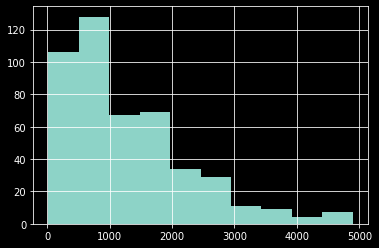

count     464.000000
mean     1291.543103
std       974.182578
min        18.000000
25%       535.250000
50%       986.000000
75%      1803.000000
max      4896.000000
dtype: float64

In [6]:
# Testing set's features distribution
test_len = [len(x) for x in proteins_test]
pd.Series(test_len).hist()
plt.show()
pd.Series(test_len).describe()

As we can see, both the training and the testing sets have a mean size on samples of 1200/1300. So it could be a good idea to pad sequences shorter than 1275 and truncate sequences longer than 1275.

In [0]:
trunc_len=3000

proteins_train = utl.pad_features(proteins_train, trunc_len)
proteins_test = utl.pad_features(proteins_test, trunc_len)

In [8]:
# Some statistics
print("Vocabulary size: {}".format(len(vocab_to_int)))
print(vocab_to_int)

Vocabulary size: 21
{'L': 1, 'S': 2, 'P': 3, 'G': 4, 'R': 5, 'A': 6, 'T': 7, 'Q': 8, 'V': 9, 'E': 10, 'K': 11, 'I': 12, 'F': 13, 'D': 14, 'N': 15, 'C': 16, 'H': 17, '-': 18, 'Y': 19, 'W': 20, 'M': 21}


In [9]:
# Training
proteins_lens = Counter([len(x) for x in proteins_train])
print("Zero-length proteins: {}".format(proteins_lens[0]))
print("Maximum protein length: {}".format(max(proteins_lens)))
print("Average protein length: {}".format(np.mean([len(x) for x in proteins_train])))

Zero-length proteins: 0
Maximum protein length: 3000
Average protein length: 3000.0


In [10]:
# Testing
proteins_lens = Counter([len(x) for x in proteins_test])
print("Zero-length proteins: {}".format(proteins_lens[0]))
print("Maximum protein length: {}".format(max(proteins_lens)))
print("Average protein length: {}".format(np.mean([len(x) for x in proteins_test])))

Zero-length proteins: 0
Maximum protein length: 3000
Average protein length: 3000.0


## Create training, validation and testing sets
In order to train a network we need to split the entire dataset into subsets, and some of them are used as never seen data. We must not use the whole dataset both for training and for testing, because we could overfit the network. We have to simulate to be in a real context, i.e. using the model to predict new available data in such a moment. To fit this rule we split data in two different datasets:
* Training dataset: used to train the network, it represents already available data
* Testing dataset: used when the model has been trained, it tests how much well the network works

For this analysis, we have decided to use a fraction of splitting equals to 0.80, i.e. the training set will be equals to 80% of the original one, while testing set will contain the remaining 20% of data.

In [11]:
X_train, y_train = proteins_train, labels_train

print("Data Set Size")
print("Train set: \t\t{}".format(X_train.shape))

Data Set Size
Train set: 		(1856, 3000)


## Training operations

In [0]:
# Decide if using a pre-trained model
use_pretrained=False
pretrained_path=base_dir+'20191102-151628/model_20191102-151628.hdf5'
starting_learning_rate=0.001

In [0]:
# Create a new directory for saving logs and the final model
os.mkdir(model_dir)

# Print params to a file
utl.print_params_to_json(params, model_dir+'/params.json')

with open(model_dir + '/log_' + sub_dir + '.txt',"w+") as log:
  if use_pretrained:
    utl.print_and_write(log, 'Performing fine-tuning on a pretrained model.\n')
    utl.print_and_write(log, 'Model dir: {}\n'.format(pretrained_path))
    utl.print_and_write(log, 'Starting learning rate: {}\n'.format(starting_learning_rate))

    # Load the pretrained model
    model=tf.keras.models.load_model(pretrained_path, compile=False)
    # model.summary(print_fn=lambda x: log.write(x + '\n'))

    global optimizer
    if params['architecture']['optimizer'] == 'ADAM':
      optimizer = tf.keras.optimizers.Adam(lr=starting_learning_rate, clipnorm=params['architecture']['clip_norm'])
    elif params['architecture']['optimizer'] == 'RMSprop':
      optimizer = tf.keras.optimizers.RMSprop(lr=starting_learning_rate, clipnorm=params['architecture']['clip_norm'])

    # Compile the new model        
    model.compile(loss=params['architecture']['loss'],
                  optimizer=optimizer,
                  metrics=params['architecture']['metrics'])
  
  else:
    model = utl.initialize_model(params['architecture'])
    
  # Print model's architecture on file
  model.summary(print_fn=lambda x: log.write(x + '\n'))

  # Fit the model on the entire dataset
  utl.train(X_train, y_train, model, log, params['seed'], params['n_epochs'], 
        params['batch_size'], 
        [eval(cb['callback_name']) for cb in params['callbacks']])    

  # Save the model
  tf.keras.models.save_model(model, model_dir + '/model_' + sub_dir + '.hdf5')
  utl.print_and_write(log, "\nModel saved into folder {}\n".format(model_dir + '/model_' + sub_dir))
  utl.print_and_write(log, "------------------------------------------\n")

  print('Task done, bye.')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

*** TRAINING PHASE ***

Train on 1392 samples, validate on 464 samples
Epoch 1/15
1392/1392 [==============================] - 61s 44ms/sample - loss: 0.7380 - acc: 0.5359 - val_loss: 0.7316 - val_acc: 0.6056
Epoch 2/15
1392/1392 [==============================] - 59s 42ms/sample - loss: 0.7234 - acc: 0.5726 - val_loss: 0.7208 - val_acc: 0.5819
Epoch 3/15
1392/1392 [==============================] - 59s 42ms/sample - loss: 0.7114 - acc: 0.6049 - val_loss: 0.7136 - val_acc: 0.6228
Epoch 4/15
1392/1392 [==============================] - 59s 42ms/sample - loss: 0.7012 - acc: 0.6128 - val_loss: 0.7073 - val_acc: 0.6336
Epoch 5/15
1392/1392 [==============================] - 59s 42ms/sample - loss: 0.6877 - acc: 0.6336 - val_loss: 0.7050 - val_acc: 0.5754
Epoch 6/15
1392/1392 [==============================] - 59s 42m

## Testing operations

In [0]:
X_test, y_test = proteins_test, labels_test

print("Data Set Size")
print("Test set: \t\t{}".format(X_test.shape))

In [0]:
# Load the model
model = tf.keras.models.load_model(model_dir + '/model_' + sub_dir + '.hdf5')

In [0]:
# Test the model
with open(model_dir + '/log_' + sub_dir + '.txt', 'a+') as log:
  score = model.evaluate(X_test, y_test, verbose=1, batch_size=params['batch_size'])
  log.write("\n*** TESTING PHASE ***\n")
  print ("%s: %.2f%%\n" % (model.metrics_names[1], score[1]*100))
  log.write("%s: %.2f%%\n" % (model.metrics_names[1], score[1]*100))

## Confusion matrix on the testing set

In [0]:
pred_labels=model.predict_classes(X_test, batch_size=params['batch_size'])
tn, fp, fn, tp = confusion_matrix(y_test, pred_labels).ravel()
print("True negative: %d" % tn)
print("True positive: %d" % tp)
print("False negative: %d" % fn)
print("False positive: %d" % fp)

In [0]:
# ROC Curve
y_predict = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_predict)
auc = auc(fpr, tpr)

print("AUC: %.2f" % auc)

In [0]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'w--')
plt.plot(fpr, tpr, label='Un. LSTM proteins\' model (area = {:.3f})'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()